# Time Series Tasks

## Regression

- ANN
- LSTM
- CNN
- CNN + LSTM

## Classification

In [204]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
if tf.config.list_logical_devices("GPU") : print("GPU detected.")
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score

from tensorflow.keras.layers import Dense,Dropout,LSTM, Input, Flatten, Conv2D, MaxPool2D, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.backend import sign

import math

import plotly.graph_objects as go
import plotly.express as px

GPU detected.


In [2]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['value']=scaler.fit_transform(df['value'].values.reshape(-1,1))
    return df

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

## FGSM
![fgsm](https://miro.medium.com/max/432/1*PAF7Lj2lcMw4kuRqBYhlYA.png)

## PGD
![pgd]()


In [195]:
def fgsm_attack(X_test, y_test, model, epsilon):
    inp = tf.convert_to_tensor(X_test, dtype = tf.float32)
    imgv = tf.Variable(inp)
    with tf.GradientTape() as tape:
        tape.watch(imgv)
        predictions = model(imgv)
        loss = tf.keras.losses.MeanSquaredError()(y_test, predictions)
        grads = tape.gradient(loss,imgv)
    signed_grads = tf.sign(grads)
    inp = inp + (epsilon*signed_grads)

    return inp

def pgd_attack(X_test, y_test, model, iterations, alpha, epsilon):
    
    gen_img = tf.convert_to_tensor(X_test, dtype=tf.float32)
    gen_img = tf.clip_by_value(gen_img, X_test-epsilon, X_test+epsilon)
    x_temp = X_test

    for iters in range(iterations):
        imgv = tf.Variable(gen_img)
        with tf.GradientTape() as tape:
            tape.watch(imgv)
            predictions = model(imgv)
            loss = tf.keras.losses.MeanSquaredError()(y_test, predictions)
            grads = tape.gradient(loss,imgv)

        signed_grads = tf.sign(grads)
        gen_img = gen_img + (alpha*signed_grads)
        gen_img = tf.clip_by_value(gen_img, X_test-epsilon, X_test+epsilon)

        
    return gen_img

In [4]:
fpath='data/hourly-energy-consumption/AEP_hourly.csv'
df=pd.read_csv(fpath)
df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.columns = ["value"]
display(df.head())

df_norm = normalize_data(df)
df_norm.shape

,value
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


(121273, 1)

In [5]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(0, len(stock)-seq_len, seq_len+1):
        X_train.append(stock.iloc[i: i+seq_len, 0])
        y_train.append(stock.iloc[i+seq_len, 0])
        
    #last 1000 days are going to be used in test
    X_test = X_train[4053:]             
    y_test = y_train[4053:]
    
    #first 4053 days are going to be used in training
    X_train = X_train[:4053]           
    y_train = y_train[:4053]
    
    # convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (4053, seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

#create train, test data
seq_len = 23 #choose sequence length

X_train, y_train, X_test, y_test = load_data(df_norm, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (4053, 23, 1)
y_train.shape =  (4053,)
X_test.shape =  (1000, 23, 1)
y_test.shape =  (1000,)


In [190]:
# build model
lstm_model = Sequential()
lstm_model.add(LSTM(23,activation="tanh", input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()

lstm_model_2 = Sequential()
lstm_model_2.add(LSTM(23,activation="tanh", input_shape=(X_train.shape[1],1), return_sequences=True))
lstm_model_2.add(Dropout(0.15))
lstm_model_2.add(LSTM(23,activation="tanh", input_shape=(X_train.shape[1],1)))
lstm_model_2.add(Dense(1))

annModel = Sequential()
annModel.add(Dense(23, activation='relu', input_dim=X_train.shape[1]))
annModel.add(Dense(1))

models = {
    "lstm_model": lstm_model,
    "lstm_model_2": lstm_model_2,
#     "annModel": annModel
    }


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 23)                2300      
                                                                 
 dropout_2 (Dropout)         (None, 23)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 24        
                                                                 
Total params: 2,324
Trainable params: 2,324
Non-trainable params: 0
_________________________________________________________________


In [193]:
model = annModel
model.summary()
# train LSTM model
model.compile(optimizer="adam",loss="MSE")
model.fit(X_train, y_train, epochs=10)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 23)                552       
                                                                 
 dense_7 (Dense)             (None, 1)                 24        
                                                                 
Total params: 576
Trainable params: 576
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
127/127 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 2/10
127/127 [==============================] - 0s 1ms/step - loss: 9.1344e-04
Epoch 3/10
127/127 [==============================] - 0s 1ms/step - loss: 9.1323e-04
Epoch 4/10
127/127 [==============================] - 0s 1ms/step - loss: 8.5983e-04
Epoch 5/10
127/127 [==============================] - 0s 1ms/step - loss: 8.2781e-04
Epoch 6/10
127/127 [===========

In [206]:
def cnnpred_2d(input_shape: tuple):

    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    return model

model = cnnpred_2d((23,1))
model.summary()
# train LSTM model
model.compile(optimizer="adam",loss="MSE")
model.fit(X_train, y_train, epochs=10)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 22, 64)            192       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 704)               0         
                                                                 
 dense_10 (Dense)            (None, 50)                35250     
                                                                 
 dense_11 (Dense)            (None, 1)                 51        
                                                                 
Total params: 35,493
Trainable params: 35,493
Non-trainable params: 0
__________________________________________________

In [207]:
lstm_predictions = model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",round(lstm_score,2))

R^2 Score of LSTM model =  0.98


In [9]:
lstm_predictions = lstm_predictions.reshape((lstm_predictions.shape[0]))
print("RMSE :",round(math.sqrt(mean_squared_error(y_test, lstm_predictions))*100,2))
print("MAPE :",round(mape(y_test, lstm_predictions),2))

RMSE : 2.62
MAPE : 6.38


### Adversarial Attack (FGSM)

In [197]:
adversarial = fgsm_attack(X_test, y_test, model, 0.01)

ValueError: Failed to find data adapter that can handle input: <class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>, <class 'NoneType'>

In [118]:
adversarial_prediction = model.predict(adversarial).T[0]
adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
adversarial_mape = round(mape(y_test, adversarial_prediction),2)
print("FGSM Adversarial R^2 : ", adversarial_score_r2)
print("FGSM Adversarial RMSE : ", adversarial_rmse)
print("FGSM Adversarial MAPE : ", adversarial_mape)

FGSM Adversarial R^2 :  0.94
FGSM Adversarial RMSE :  3.19
FGSM Adversarial MAPE :  7.52


### Results

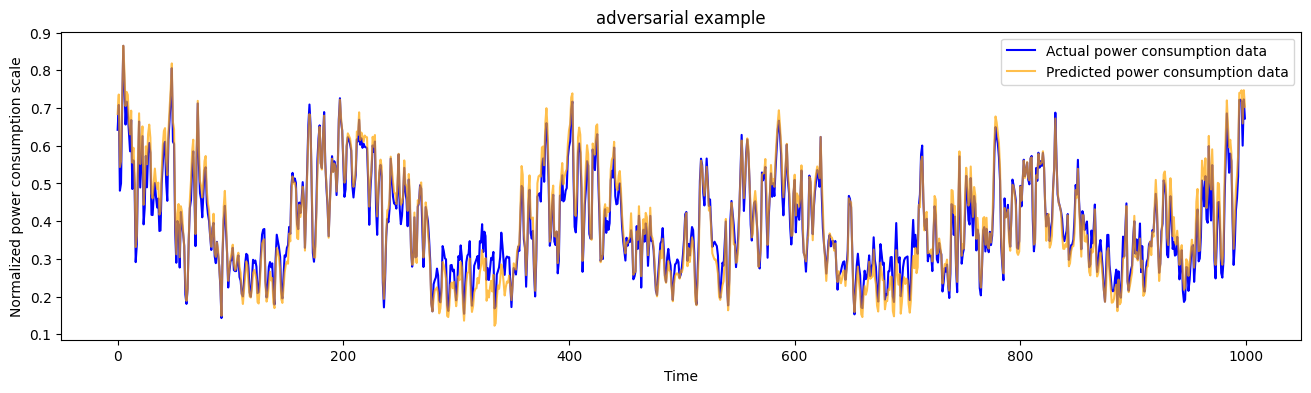

In [37]:
plot_predictions(y_test, adversarial_prediction, "adversarial example")

In [44]:
fig = go.Figure(go.Scatter(y=y_test))
fig.add_trace(go.Scatter(y=adversarial_prediction))
fig

### Adversarial Attack (PGD)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FGSM Adversarial R^2 :  -0.27
FGSM Adversarial RMSE :  14.37
FGSM Adversarial MAPE :  39.2


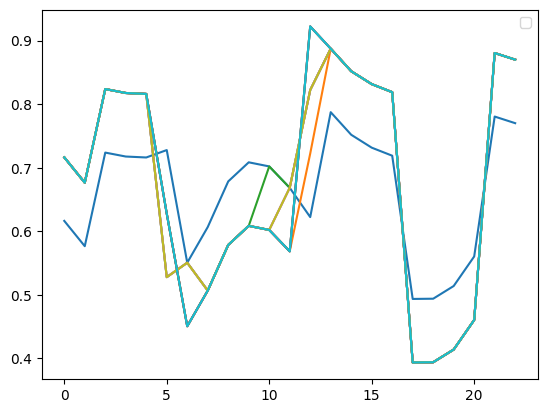

PGD Adversarial R^2 :  -3.95
PGD Adversarial RMSE :  28.37
PGD Adversarial MAPE :  78.8


In [185]:
adversarial = fgsm_attack_new(X_test, y_test, model, 0.1)

adversarial_prediction = model.predict(adversarial).T[0]
adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
adversarial_mape = round(mape(y_test, adversarial_prediction),2)
print("FGSM Adversarial R^2 : ", adversarial_score_r2)
print("FGSM Adversarial RMSE : ", adversarial_rmse)
print("FGSM Adversarial MAPE : ", adversarial_mape)

#############
#############
adversarial = pgd_attack(X_test, y_test, model, 10, 0.1, 0.2)

adversarial_prediction = model.predict(adversarial).T[0]
adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
adversarial_mape = round(mape(y_test, adversarial_prediction),2)
print("PGD Adversarial R^2 : ", adversarial_score_r2)
print("PGD Adversarial RMSE : ", adversarial_rmse)
print("PGD Adversarial MAPE : ", adversarial_mape)

In [146]:
fig = go.Figure(go.Scatter(y=adversarial.numpy()[0].T[0]))
fig.add_trace(go.Scatter(y=X_test[0].T[0]))
fig

In [76]:
from absl import app, flags
FLAGS = flags.FLAGS

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [109]:
alpha = 0.1
epsilon = 0.1
x_pgd = fast_gradient_method(model, X_test, epsilon, np.inf)
y_pred_pgd = model.predict(x_pgd).T[0]

adversarial_score_r2 = round(r2_score(y_test, y_pred_pgd),2)
adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, y_pred_pgd.reshape(1,-1)[0]))*100,2)
adversarial_mape = round(mape(y_test, y_pred_pgd),2)
print("FGSM Adversarial R^2 : ", adversarial_score_r2)
print("FGSM Adversarial RMSE : ", adversarial_rmse)
print("FGSM Adversarial MAPE : ", adversarial_mape)

#############
#############

alpha = 0.1
epsilon = 0.1
x_pgd = projected_gradient_descent(model, X_test[0], alpha, epsilon, 100, np.inf)
y_pred_pgd = model.predict(x_pgd).T[0]

adversarial_score_r2 = round(r2_score(y_test, y_pred_pgd),2)
adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, y_pred_pgd.reshape(1,-1)[0]))*100,2)
adversarial_mape = round(mape(y_test, y_pred_pgd),2)
print("PGD Adversarial R^2 : ", adversarial_score_r2)
print("PGD Adversarial RMSE : ", adversarial_rmse)
print("PGD Adversarial MAPE : ", adversarial_mape)

FGSM Adversarial R^2 :  0.96
FGSM Adversarial RMSE :  2.62
FGSM Adversarial MAPE :  6.38


ValueError: Found input variables with inconsistent numbers of samples: [1000, 23]

In [115]:
alpha = 1
epsilon = 1
x_pgd = projected_gradient_descent(model, X_test[0], alpha, epsilon, 10, np.inf)
fig = go.Figure(go.Scatter(y=x_pgd.numpy().T[0]))
fig.add_trace(go.Scatter(y= X_test[0].T[0]))
fig

In [157]:
# for alpha in [0.1,0.2,0.5,1,2,3,5,10,15]:
mapes = []
eps_list = [round(1*(math.pow(10,i/10)),3) for i in range(-30,1,2)]
eps_list = [0,0.000001, 0.001, 0.01]
for epsilon in eps_list:

    iterations = 10
    alpha = 0
#         epsilon = 5/100

    adversarial = pgd_attack(X_test, y_test, model, iterations, alpha, epsilon)

    adversarial_prediction = model.predict(adversarial)

    adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
    adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
    adversarial_mape = round(mape(y_test, adversarial_prediction),2)
    
    mapes.append(adversarial_mape)
#         print("PGD Adversarial R^2 : ", adversarial_score_r2)
#         print("PGD Adversarial RMSE : ", adversarial_rmse)
#         print("PGD Adversarial MAPE : ", adversarial_mape)

#     print("alpha :", round(alpha/1,2), " epsilon :", round(epsilon/1,2),"\t", adversarial_score_r2, adversarial_rmse, adversarial_mape)

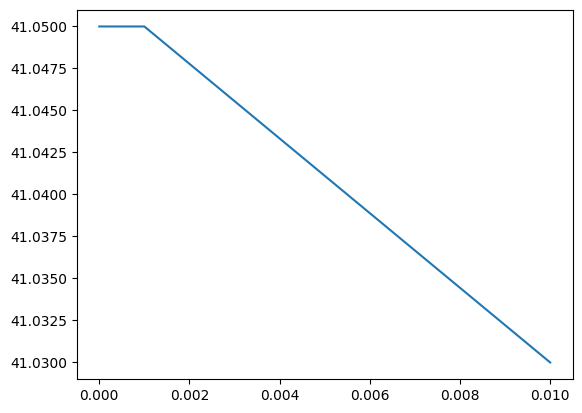

In [158]:
plt.plot(eps_list, mapes)
plt.show()

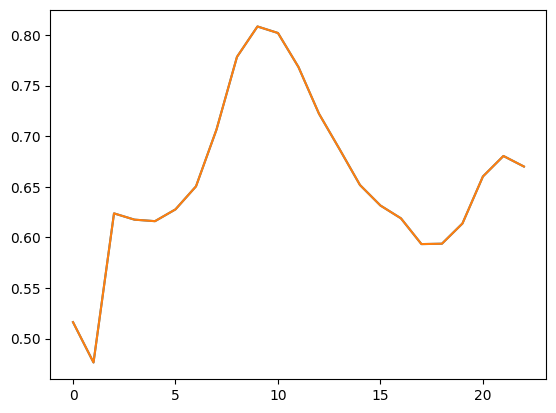

MAPE: 40.37 40.37


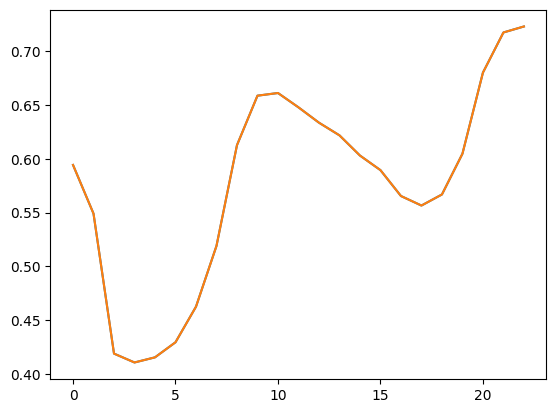

In [178]:
iterations = 0
alpha = 0
epsilon = 0
adversarial = pgd_attack(X_test, y_test, model, iterations, alpha, epsilon)

org_prediction = model.predict(X_test)
adversarial_prediction = model.predict(adversarial)

org_mape = round(mape(y_test, org_prediction),2)
adversarial_mape = round(mape(y_test, adversarial_prediction),2)
print("MAPE:",round(org_mape,2), round(adversarial_mape,2))

plt.plot(adversarial[1].numpy())
plt.plot(X_test[1])
plt.show()

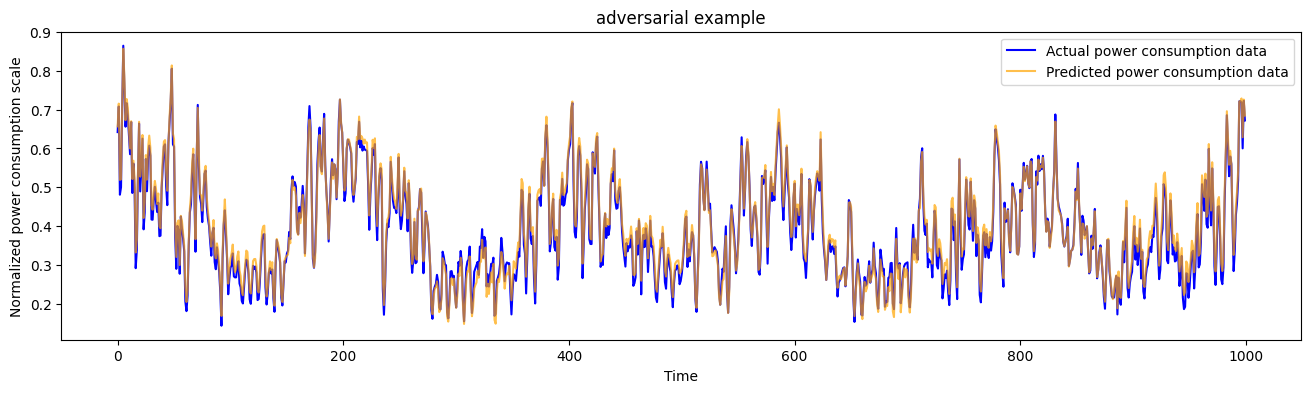

In [169]:
plot_predictions(y_test, adversarial_prediction, "adversarial example")

In [16]:
metric_df = {}
for metric in ["R2", "MAPE", "RMSE"]:
    metric_df[metric] = pd.DataFrame(index = models.keys(), columns = ["Vanilla", "FGSM", "PGD"])

Epoch 1/10
127/127 [==============================] - 3s 23ms/step - loss: 0.0047
Epoch 2/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0038
Epoch 3/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0034
Epoch 4/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0031
Epoch 5/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0028
Epoch 6/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0027
Epoch 7/10
127/127 [==============================] - 3s 23ms/step - loss: 0.0029
Epoch 8/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0027
Epoch 9/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0026
Epoch 10/10
127/127 [==============================] - 3s 24ms/step - loss: 0.0025
R^2 : 0.95
RMSE : 2.76
MAPE : 6.68
FGSM Adversarial R^2 :  0.95
FGSM Adversarial RMSE :  2.76
FGSM Adversarial MAPE :  39.65


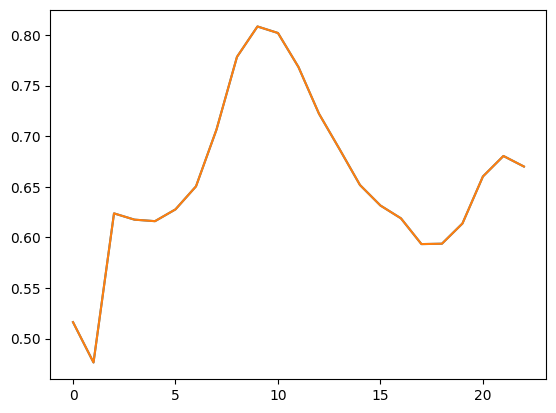

PGD Adversarial R^2 :  0.95
PGD Adversarial RMSE :  2.76
PGD Adversarial MAPE :  39.65
MAPE : 6.68
Epoch 1/10
127/127 [==============================] - 7s 49ms/step - loss: 0.0026
Epoch 2/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0024
Epoch 3/10
127/127 [==============================] - 6s 49ms/step - loss: 0.0022
Epoch 4/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0020
Epoch 5/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0020
Epoch 6/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0018
Epoch 7/10
127/127 [==============================] - 6s 49ms/step - loss: 0.0017
Epoch 8/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0016
Epoch 9/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0016
Epoch 10/10
127/127 [==============================] - 6s 48ms/step - loss: 0.0015
R^2 : 0.96
RMSE : 2.54
MAPE : 5.88
FGSM Adversarial R^2 :  0.96
FGSM Adversarial

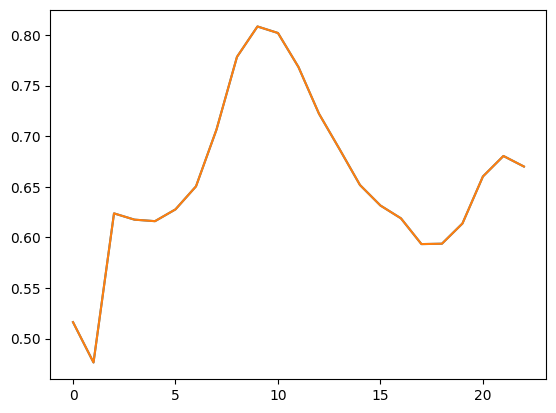

PGD Adversarial R^2 :  0.96
PGD Adversarial RMSE :  2.54
PGD Adversarial MAPE :  40.19
MAPE : 5.88


In [181]:
for item in models.items():
    
    model = item[1]
    #Train
    model.compile(optimizer="adam",loss="MSE")
    model.fit(X_train, y_train, epochs=10)
    
    preds = model.predict(X_test)
    R2_score = r2_score(y_test, preds)
    print("R^2 :",round(R2_score,2))
    preds = preds.reshape((preds.shape[0]))
    print("RMSE :",round(math.sqrt(mean_squared_error(y_test, preds))*100,2))
    print("MAPE :",round(mape(y_test, preds),2))
    
    metric_df["R2"].loc[item[0], "Vanilla"] = round(R2_score,2)
    metric_df["MAPE"].loc[item[0], "Vanilla"] = round(mape(y_test, preds),2)
    metric_df["RMSE"].loc[item[0], "Vanilla"] = round(math.sqrt(mean_squared_error(y_test, preds))*100,2)
    
    #FGSM
    adversarial_fgsm = fgsm_attack(X_test, 0.01, mean_squared_error(y_test, preds))
    adversarial_prediction = model.predict(adversarial_fgsm)
    adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
    adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
    adversarial_mape = round(mape(y_test, adversarial_prediction),2)
    print("FGSM Adversarial R^2 : ", adversarial_score_r2)
    print("FGSM Adversarial RMSE : ", adversarial_rmse)
    print("FGSM Adversarial MAPE : ", adversarial_mape)
    
    metric_df["R2"].loc[item[0], "FGSM"] = adversarial_score_r2
    metric_df["MAPE"].loc[item[0], "FGSM"] = adversarial_mape
    metric_df["RMSE"].loc[item[0], "FGSM"] = adversarial_rmse
    
    #PGD
    adversarial_pgd = pgd_attack(X_test, y_test, model, 0,0,0)
    adversarial_prediction = model.predict(adversarial_pgd)
    adversarial_score_r2 = round(r2_score(y_test, adversarial_prediction),2)
    adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, adversarial_prediction.reshape(1,-1)[0]))*100,2)
    adversarial_mape = round(mape(y_test, adversarial_prediction),2)
    print("PGD Adversarial R^2 : ", adversarial_score_r2)
    print("PGD Adversarial RMSE : ", adversarial_rmse)
    print("PGD Adversarial MAPE : ", adversarial_mape)
    print("MAPE :",round(mape(y_test, preds),2))
    
    metric_df["R2"].loc[item[0], "PGD"] = adversarial_score_r2
    metric_df["MAPE"].loc[item[0], "PGD"] = adversarial_mape
    metric_df["RMSE"].loc[item[0], "PGD"] = adversarial_rmse
    


In [182]:
for metric in metric_df.items():
    print(metric[0])
    display(metric[1])

R2


,Vanilla,FGSM,PGD
lstm_model,0.95,0.95,0.95
lstm_model_2,0.96,0.96,0.96


MAPE


,Vanilla,FGSM,PGD
lstm_model,6.68,39.65,39.65
lstm_model_2,5.88,40.19,40.19


RMSE


,Vanilla,FGSM,PGD
lstm_model,2.76,2.76,2.76
lstm_model_2,2.54,2.54,2.54


In [ ]:
# from foolbox import TensorFlowModel, accuracy, samples, Model
# from foolbox.attacks import LinfPGD

# fmodel: Model = TensorFlowModel(model, bounds=(0, 1))
# fmodel = fmodel.transform_bounds((0, 1))

# clean_acc = accuracy(fmodel, X_test, y_test)
# print(f"clean accuracy:  {clean_acc * 100:.1f} %")

# # apply the attack
# attack = LinfPGD()
# epsilons = [
#     0.0,
#     0.0002,
#     0.0005,
#     0.0008,
#     0.001,
#     0.0015,
#     0.002,
#     0.003,
#     0.01,
#     0.1,
#     0.3,
#     0.5,
#     1.0,
# ]
# raw_advs, clipped_advs, success = attack(fmodel, X_test, y_test, epsilons=epsilons)

In [19]:
from absl import app, flags
FLAGS = flags.FLAGS

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [122]:
x_pgd = projected_gradient_descent(lstm_model, X_test, 0.1, 0.01, 10, np.inf)
y_pred_pgd = lstm_model(x_pgd)
y_pred_pgd = y_pred_pgd.numpy()


adversarial_score_r2 = round(r2_score(y_test, y_pred_pgd),2)
adversarial_rmse = round(math.sqrt(mean_squared_error(y_test, y_pred_pgd.reshape(1,-1)[0]))*100,2)
adversarial_mape = round(mape(y_test, y_pred_pgd),2)
print("PGD Adversarial R^2 : ", adversarial_score_r2)
print("PGD Adversarial RMSE : ", adversarial_rmse)
print("PGD Adversarial MAPE : ", adversarial_mape)

PGD Adversarial R^2 :  0.93
PGD Adversarial RMSE :  3.44
PGD Adversarial MAPE :  39.14


In [ ]:
x = tf.placeholder(tf.float32, (299, 299, 3))

x_hat = image # our trainable adversarial input
assign_op = tf.assign(x_hat, x)

learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])